In [1]:
import json
import tensorflow as tf
try:
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
except Exception:
    pass

print(tf.__version__)

2.2.0


In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [3]:
data = [json.loads(line) for line in open('Sarcasm_Headlines_Dataset_v2.json', 'r')]

sentence = []
labels = []

for item in data:
    sentence.append(item['headline'])
    labels.append(item['is_sarcastic'])
    
print(len(labels))
print(labels[0])


28619
1


In [4]:
train_sent = sentence[0:training_size]
test_sent = sentence[training_size:]
train_label = labels[0:training_size]
test_label = labels[training_size:]

In [5]:
tokens = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokens.fit_on_texts(train_sent)


word_index = tokens.word_index

training_sqeunece = tokens.texts_to_sequences(train_sent)
training_padding = pad_sequences(training_sqeunece, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_squence = tokens.texts_to_sequences(test_sent)
testing_padding = pad_sequences(testing_squence, maxlen=max_length, padding = padding_type, truncating=trunc_type)


In [6]:
import numpy as np

training_padded = np.array(training_padding)
training_labels = np.array(train_label)
testing_padded = np.array(testing_padding)
test_labels = np.array(test_label)



In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [9]:
num_epochs = 50
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
histroy = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels))

Epoch 1/50
625/625 [==============================] - 3s 5ms/step - loss: 0.6698 - accuracy: 0.5785 - val_loss: 0.5842 - val_accuracy: 0.8054

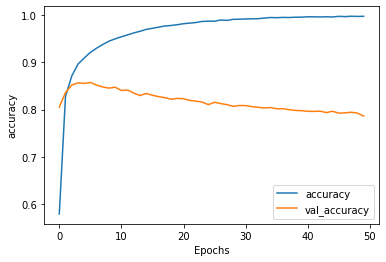

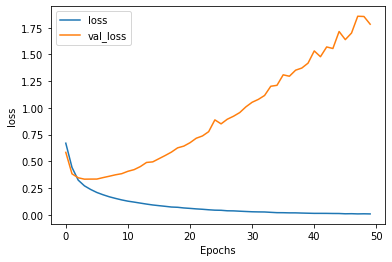

In [10]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(histroy, "accuracy")
plot_graphs(histroy, "loss")


In [11]:
reverse_word_index = dict([value, key] for (key, value) in word_index.items())

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print(train_sent[0])
print(labels[0])

<OOV> scientists unveil doomsday clock of hair loss ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
thirtysomething scientists unveil doomsday clock of hair loss
1


In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


In [13]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')

out_v.close()
out_m.close()



In [14]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')



In [16]:
text = decode_sentence(testing_padded[2])
print(text)

sentence = [text]
sequences = tokens.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predicts = model.predict(padded)
print(predicts)
print('sarcastic' if (predicts > 0.5) else 'Not sarcastic')


amy schumer plays a revealing game of 'would you <OOV> ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
[[1.8408837e-05]]
Not sarcastic
